In [1]:
import pandas as pd
from matplotlib import pyplot as plt

# high resolution plots
%config InlineBackend.figure_format = 'retina'

# Evaluation of the route choice experiment

In [2]:
data = pd.read_csv('csv-file_route-choice_cropped.csv', parse_dates=['Timestamp'], index_col='Timestamp')
data.sort_index(inplace=True)

In [3]:
labelGMaps = 'Google Maps'
labelNunav = 'Nunav Navigation'

In [4]:
maskGMaps = data['Label'] == 'Google Maps'
maskNunav = data['Label'] == 'Nunav Swarm'

print('GMaps: %d sessions'%len(data[maskGMaps]['SessionID'].value_counts()))
print('NUNAV: %d sessions'%len(data[maskNunav]['SessionID'].value_counts()))

GMaps: 22 sessions
NUNAV: 17 sessions


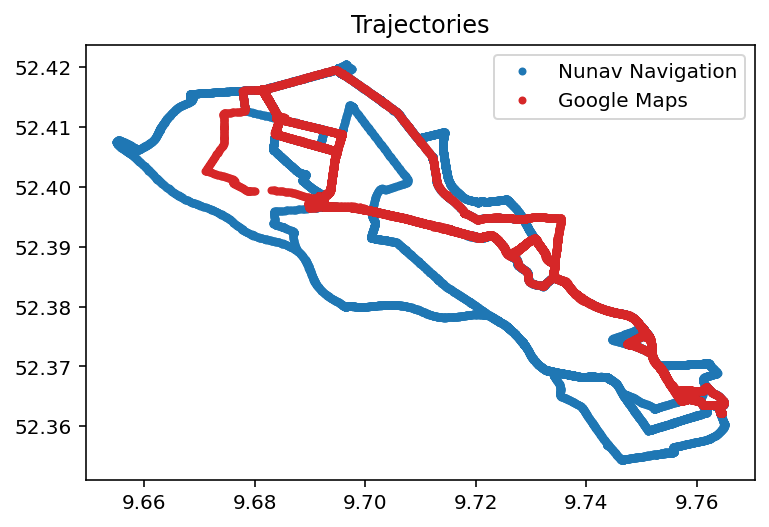

In [5]:
plt.plot(data[maskNunav].Longitude, data[maskNunav].Latitude, '.', label=labelNunav)
plt.plot(data[maskGMaps].Longitude, data[maskGMaps].Latitude, '.', color='C3', label=labelGMaps)
    
plt.title('Trajectories')
plt.legend()

In [6]:
# detect the standing duration when the speed is below this value
speedThresholdLow = 5 # km/h
# ...until it is above this threshold:
speedThresholdHigh = 10 # km/h

summary = pd.DataFrame()

for sessionID in data['SessionID'].value_counts().index :
    mask = (data['SessionID'] == sessionID) 
    trajectoryData = data[mask]

    if len(trajectoryData) <= 1 :
        continue

    #travelDistance = trajectoryData.distance[-1] - trajectoryData.distance[0] # last value minus first value
    travelTime = (trajectoryData.index[-1] - trajectoryData.index[0])
    #averageSpeed = travelDistance / travelTime * 3600 # km/h
    consumptionData = trajectoryData['FuelCumulated(l)'].dropna()
    fuelConsumption = consumptionData[-1] - consumptionData[0] # last value minus first value

    standingDuration = pd.Timedelta(0)
    previousTimestamp = None
    isStanding = False
    
    for index, row in trajectoryData.iterrows() :
        if (previousTimestamp != None) & (row['Speed(km/h)'] < speedThresholdLow) :
            isStanding = True

        if isStanding & (row['Speed(km/h)'] < speedThresholdHigh):
            deltaTime = index - previousTimestamp
            standingDuration = standingDuration + deltaTime
        else :
            isStanding = False
            
        previousTimestamp = index

    summary = pd.concat([summary, pd.DataFrame(index=[sessionID], data={
            #'travelDistance': travelDistance, 
            'TravelTime (min)': travelTime.total_seconds()/60, 
            #'averageSpeed': averageSpeed, 
            'Stops (min)': standingDuration.total_seconds()/60,
            'Fuel Consumption (l)': fuelConsumption,
            'Group': trajectoryData['Group'][0],
            'Label': trajectoryData['Label'][0]

        })])

In [7]:
summary.drop(columns=['Group']).groupby(['Label']).mean()

,TravelTime (min),Stops (min),Fuel Consumption (l)
Label,,,
Google Maps,34.437863,14.999435,1.067911
Nunav Swarm,30.589976,11.115839,1.048079


### Geographic groups

Split by group (see trajectory-geojson files)

In [8]:
summary.groupby(['Label', 'Group']).mean()

TravelTime (min)  Stops (min)  Fuel Consumption (l)
Label       Group                                                     
Google Maps 3             34.807491    15.291061              1.076782
            4             30.741583    12.083175              0.979197
Nunav Swarm 1             27.937421     9.149433              1.133970
            2             33.144450    12.481622              1.045076
            3             31.282623    11.418487              1.001619
            4             30.486690    11.566847              1.027630